## CS 169 - Final
### By Sanath Nair, Vicki Bui, Lance Li, Anthony Wen

## Introduction

Our project aims to solve a problem affecting many metropolitan areas around the world: *What is the most optimal bus route to get as many passengers to and from different stops*. While there is more subtlety to the problem such as multiple lines, traffic delays, cost of creating lines, etc, we decided to solve the base problem: ***Given a set of bus stops what is the optimal bus route that maximizes passengers transported in the least amount of time***

This problem is very similar to the Traveling Salesman Problem (TSP) in that we are looking for the optimal route between various stops. However, the objective function in our case contains both information about the distance between stops and also the number of passengers being benefited by the route. This incentives the algorithm to take routes that are both short and get as many people from point A to B.

***[Written by Sanath]***

## Novelty

Our project differs from the Traveling Salesman Problem in the aspect of the objective function. 

The main focus of this project is to optimize the number of passengers delivered by time. We are seeking the maximum of this cumulative reward incentivizing the algorithm to choose the route that picks up and the maximum number of passengers with the cost of time.

In contrast to the TSP problem which is trying to find the minimum Euclidean Distance between various cities. The TSP problem also focus on the relationship between two adjacent stops but our objective function looks at the bus route as a whole. For example, people who gets on the bus in front of the school would want to get to Plaza Verde and Vista Del Campo North(VDCN), but since the immediate stop after the school if Plaza Verde, the TSP problem neglects the relationship between school to VDCN. TSP looks at stops as pairs and our algorithm looks at it as a whole. This nature adds on to the complexity of our objective function.

***[Written by Lance]***

## Literature Review

Before designing an optimization algorithm to solve our problem we did some research on existing papers to see what results these researchers found. One article that stood out was this [Research Paper on optimizing bus routes](https://www.sciencedirect.com/science/article/pii/S1077291X22004039). The authors of this article similar to us designed a grid based bus route and an algorithm to optimize the bus route while also taking into consideration operator and user costs. Their work on creating a suitable reward function was particularly helpful in giving us a baseline for designing our own reward function.

In addition to this article we referenced both, K&W and B&C for their implementations of the algorithms we decided to implement.

***[Written by Sanath]***

## Division of Work

- 2 Developers: Sanath & Vicki
- Data Collection: Anthony
- Reward Function Design: Lance
- Poster & Paper: Lance, Anthony, Sanath, Vicki

The division of work is separated majorly as above, however everyone contributed to each other's task including debugging, designing, and proof reading.

## Code

### Imports

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

### Preface

Before we get started with implementing our two optimization techniques, we must first load our data. Since this problem can be well represented as a graph problem we used an adjacency matrix for the time between the various stops and the number of passengers traveling from one stop to another. In [Research Paper on optimizing bus routes](https://www.sciencedirect.com/science/article/pii/S1077291X22004039),the researchers implemented a matrix calculating distance with diagonal lines. We did not adapt this implementation as we didn't agree with the consistency of the relationship between distance and time. Instead we implemented a 2d matrix containing the time taken to travel from one point to the other.

*note: our data was stored as a 2d numpy array during the data collection/preprocessing phase*

***[Written by Sanath & Lance, Data collected by Anthony]***

Before we loaded our data, we had to first obtain the data. In terms of obtaining the data, we had Google Spreadsheets for Map Data and Passenger Data. Both Spreadsheets contained a 25x25 matrix to store the amount of time/passengers from column(vertical/left side) to row(horizontal/right side). Map data involved using Google Maps to find the amount of time it would take for a bus to go from one bus stop to all the other bus stops and vice versa. This took a considerable amount of time (7 hours) as we had to manually check how much time it would take for each bus stop relative to all other bus stops in order to ensure 100% accuracy. Passenger data involved estimating the amount of passengers who would get on from one bus and exit at the other bus stops. For data collection, we had a dictionary for Map Data where the key was a tuple of the starting bus stop and ending bus stop with the value being the amount of time it takes to get to the ending bus stop from starting bus stop and another for passenger data with the same key but value being the number of passengers. 

There were some challenges in storing and using the collected data changed throughout our project. Initially, we logged the data into an Google Spreadsheet. However, we did not want to have to manually input the data into dictionaries as this would take a considerable amount of time. In response to this issue, we used the numpy python library and utilized methods such as np.array, np.save, and np.load to read the Google Spreadsheet and convert the data into dictionaries for us. These three methods significantly reduced our time complexity of storing and using the collected data.

***[Written by Sanath & Anthony]***

In [2]:
bus_stops_adj_matrix = np.load("bus_adjacency_matrix.npy")
passenger_adj_matrix = np.load("passenger_adjacency_matrix.npy")

![labelled map](/Users/sanathnair/Developer/cs169/final/labelled_map.png)

In [3]:
# small glimpse of the data
# each row represents the starting bus stop and the column represents the ending bus stop
# the value in the matrix represents the time it takes to travel between the two bus stops
bus_stops_adj_matrix[:5, :5]

array([[100.,   3.,   1.,   2.,   2.],
       [100., 100.,   4.,   4.,   4.],
       [  5.,   4., 100.,   5.,   1.],
       [  3.,   1.,   4., 100.,   3.],
       [  5.,   4.,   5.,   4., 100.]])

The cumulative_reward function is our objective function. We had to imagine what the total benefit one bus cycle is consist of. Passenger picked up must be dropped off. Looking deeper into this part, a bus goes from start to finish picking people up and dropping people off, but for those picked up later (after the first stop) they might want to get off in the second cycle. Just like how someone who gets on the M in front of the school may want to get dropped off at the Engineering buildings. (The M is referred to as the green line on the map starting at 6 and ending at 0.) With this in mind, we designed our objective function to do 2 loops around the route, the first loop picking passenger up and dropping off and the second loop only for drop off. This does not mean in real life the bus is not picking people up on the second loop but the passenger picked up is not counted towards the cumulative reward of one cycle.

With the above we have all the data and major calculations completed, what is next is how the cumulative reward is calculated. We've tested many different composition of this. Initially we thought of time/passenger, this would mean we want to minimize the cumulative reward. On paper it means making this bus route be as fast as possible. This was a failure since the most optimal result would be the bus just not moving. We quickly spot the problem and looked into an addition relationship with weight trying to incentivize picking up passenger and taking less time. This worked out somewhat, the results were not ideal as it would mix up the relationship between passenger and time. At the end, we explored flipping the original implementation, now passenger/time, and seek the maximum instead of minimum. This was successful, the results were pretty good but there was still slight issues of the algorithm taking short paths with little passengers. To fix this, we added the weight characteristic from the previous attempt into this calculation, we multiplied the time by 100 and added 100, this was to scale up the time but adding a constant so smaller times would have a much higher increase in change. (1 vs 10 to 200 vs 1100, a 200% increase vs 110% increase). With that we finalize on the calculation of the objective function.
***[Written and Developed by Lance]***

In [4]:
def cumulative_reward(bus_route, bus_adjacency_matrix, passenger_adjacency_matrix):
    """
    calculate the cumulative reward of the bus route.

    Args:
        bus_route (list): The sequence of stops the bus takes.
        bus_adjacency_matrix (2d numpy array): the value at [i][j] represents the time from stop i to j
        passenger_adjacency_matrix (2d numpy array): the value at [i][j] represents the number of passengers 
            that want to go from stop i to j

    Returns:
        cumulative reward (int): The cumulative reward of all passenger transported by bus.
    """

    bus_route = [stop.id for stop in bus_route.bus_stops]

    # creates a set of pairs from stop to all possible destinations
    possible_passenger_pairs = [(x, y) for x in bus_route for y in bus_route if x != y]

    # creates a map of each pairs and how many passenger is part of each pair
    # dict: {(start, end): [# of passengers, time on bus]}
    passenger_pairs = {
        pair: [passenger_adjacency_matrix[pair[0]][pair[1]], 0]
        for pair in possible_passenger_pairs
    }

    pairs_on_bus = set()

    # pick up and drop off
    for i in range(len(bus_route)):
        curr_stop = bus_route[i]
        next_stop = bus_route[i + 1] if i != len(bus_route) - 1 else bus_route[0]
        # print("curr -> next:", (cur_stop, next_stop))
        time = bus_adjacency_matrix[curr_stop][next_stop]

        for destinations in {x for x in bus_route if x != curr_stop}:
            pairs_on_bus.add((curr_stop, destinations))

        dropped_off = set()
        for passenger in pairs_on_bus:
            passenger_pairs[passenger][1] += time
            if passenger[1] == next_stop:
                dropped_off.add(passenger)

        pairs_on_bus -= dropped_off
        # print("passenger pairs:", passenger_pairs)

    # finishing drop off
    for i in range(len(bus_route)):
        curr_stop = bus_route[i]
        next_stop = bus_route[i + 1] if i != len(bus_route) - 1 else bus_route[0]
        # print("curr -> next:", (curr_stop, next_stop))
        time = bus_adjacency_matrix[curr_stop][next_stop]

        dropped_off = set()
        for passenger in pairs_on_bus:
            passenger_pairs[passenger][1] += time
            if passenger[1] == next_stop:
                dropped_off.add(passenger)

        pairs_on_bus -= dropped_off

    return sum(
        value[0] / (100 * value[1] + 100) for value in passenger_pairs.values() if value[1] != 0
    )


In addition we will define some helper functions below to help with our implementation of each optimization algorithm.

***[Developed by Sanath]***

In [5]:
class BusStop:
    def __init__(self, id) -> None:
        # id represents the bus stop
        self.id = id
    
    def __repr__(self) -> str:
        return str(self.id)

    def __eq__(self, other):
        return self.id == other.id


class Route:
    def __init__(self, bus_stops: list[BusStop]) -> None:
        self.bus_stops = bus_stops
    
    def __repr__(self) -> str:
        return str(self.bus_stops)

    def __eq__(self, other):
        return self.bus_stops == other.bus_stops
    

### Genetic Algorithm

The first optimization method we decided to use was a Genetic Algorithm. The following code was inspired by the following [medium article](https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35). 

The way a Genetic algorithm works is by creating a population of 100 (in this case) randomly generated routes. All these routes are then ranked based on the reward function and then the top 3 are selected by default to move on to the next generation (concept known as elitism) and from the remaining routes, k of them, are randomly selected to be parents for the next generation. These parents are randomly combined to create children routes which are then passed on to the next generation. This process continues for n generations.

*note that this article was intended for the TSP problem so it was modified for our problem* 

The article implements a Fitness Proportionate Selection to choose parents to create the next generation. However after reading the following article [Research Paper on Tournament vs Roulette](https://www.researchgate.net/publication/221216912_Comparison_of_Performance_between_Different_Selection_Strategies_on_Simple_Genetic_Algorithms) we decided to implement the Tournament Selection.

***[Developed by Sanath]***

In [6]:
def rankRoutes(population, fitness_func):
    """
    given a list of different routes return a sorted list of routes based on their performance according to the fitness function
    """
    fitnessResults = {}
    for i in range(len(population)):
        fitnessResults[i] = fitness_func(population[i])
    return sorted(fitnessResults.items(), key=lambda x: x[1], reverse=True)

def createInitialPopulation(bus_stops, populationSize):
    """
    bus_stops: list of all possible stops
    populationSize: number of routes to create
    """
    pop = [Route([BusStop(i) for i in [0,2,6,8,9,10,11,12,13,14,15]])]
    return pop + [Route(random.sample(bus_stops, len(bus_stops))) for _ in range(populationSize)]


def selection(rankedPopulation, probability=0.6):
    """
    popRanked: list of tuples (route index, fitness) sorted by fitness
    eliteSize: number of best routes to keep

    This function determines which routes to use as parents for the next generation.
    According to the research article linked above Tournament style selection provides better convergence results than Roulette wheel selection.
    Therefore, we will use Tournament selection. In addition we won't use elitism as tournament style selection already provides some elitism.
    According to the medium article by Calvin McGowan, a good rule of thumb is to include roughly 20% of your population in each generation.
    """
    selectionResults = []
    tournamentSize = math.floor(math.log(len(rankedPopulation) * 0.2, 2))
    for _ in range(len(rankedPopulation)):
        participants = random.sample(rankedPopulation, tournamentSize)
        selectionResults.append(max(participants, key=lambda x: x[1]))

    return selectionResults

def mapRouteIdsToRoute(population, selectionResults):
    """
    helper function
    """
    return [population[selectionResults[i][0]] for i in range(len(selectionResults))]

def breed(parent1: Route, parent2: Route):
    """
    parent1: first parent
    parent2: second parent
    """

    parent1 = parent1.bus_stops
    parent2 = parent2.bus_stops

    geneA, geneB = random.randint(0, len(parent1) - 1), random.randint(0, len(parent1) - 1)
    startGene, endGene = min(geneA, geneB), max(geneA, geneB)

    parent1Slice = parent1[startGene:endGene]
    parent2Slice = [item for item in parent2 if item not in parent1Slice]

    return Route(parent1Slice + parent2Slice)

def breedPopulation(matingPool):
    """
    matingPool: list of routes to breed
    """
    children = []
    for i in range(len(matingPool)):
        child = breed(matingPool[i], matingPool[len(matingPool) - i - 1])
        children.append(child)
    return children

def mutate(route: Route, mutationRate):
    """
    route: route to mutate
    mutationRate: chance of mutation
    """
    for i in range(len(route.bus_stops)):
        if random.random() < mutationRate:
            j = random.randint(0, len(route.bus_stops) - 1)
            route.bus_stops[i], route.bus_stops[j] = route.bus_stops[j], route.bus_stops[i]
    return route

def mutatePopulation(population, mutationRate):
    """
    population: list of routes to mutate
    mutationRate: chance of mutation
    """
    mutatedPopulation = []
    for i in range(len(population)):
        mutatedPopulation.append(mutate(population[i], mutationRate))
    return mutatedPopulation

def nextGeneration(currentGen, fitness_func, mutationRate):
    """
    currentGen: current list of routes
    mutationRate: chance of mutation
    """
    rankedRoutes = rankRoutes(currentGen, fitness_func)
    selectionResults = selection(rankedRoutes)
    matingPool = mapRouteIdsToRoute(currentGen, selectionResults)
    children = breedPopulation(matingPool)
    nextGeneration = mutatePopulation(children, mutationRate)
    elite = [currentGen[i] for i, _ in rankedRoutes[:3]]
    return elite + nextGeneration, rankedRoutes[0][1]

def geneticAlgorithm(bus_stops, fitness_func, population_size=100, mutationRate=0.2, generations=500):
    """
    bus_stops: list of all possible stops
    mutationRate: chance of mutation
    generations: number of generations to run
    """
    population = createInitialPopulation(bus_stops, population_size)
    initialRank = rankRoutes(population, fitness_func)
    initialRoute = population[initialRank[0][0]]
    performance = []
    for _ in range(generations):
        population, bestScoreOfGen = nextGeneration(population, fitness_func, mutationRate)
        performance.append(bestScoreOfGen)

    finalRank = rankRoutes(population, fitness_func)
    finalRoute = population[initialRank[0][0]]
    return initialRank[0][1], initialRoute, finalRank[0][1], finalRoute, np.array(performance)

### Simulated Annealing

The next optimization algorithm we decided to use was Simulated Annealing. Similar to the genetic algorithm we will use the same reward function.

Simulated Annealing unlike Genetic algorithm takes one path and scrambles the order of the paths based of various combination techniques. It continues this process until the benefit from one variation to the next is stagnant. Unlike the genetic algorithm, there is a probability that the algorithm chooses a worse path. This is intentional as its supposed to help the algorithm escape local mins/maxs and reach the true optima.

The code below was modified from the following article [Solving TSP using Simulated Annealing](https://medium.com/@francis.allanah/travelling-salesman-problem-using-simulated-annealing-f547a71ab3c6). In addition to this article we took inspiration from the following [Research Paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4808530/)

***[Developed by Sanath]***

In [7]:
def inverse(state):
    """
    reverses the order of routes between two randomly choosen stops
    """
    node_one, node_two = random.sample(state, 2)
    idx_one = state.index(node_one)
    idx_two = state.index(node_two)
    state[min(idx_one, idx_two): max(idx_one, idx_two) + 1] = state[
        min(idx_one, idx_two): max(idx_one, idx_two) + 1
    ][::-1]
    return state


def insert(state):
    """
    moves a stop from position i to j
    """
    node_one, node_two = random.sample(state, 2)
    idx_one = state.index(node_one)
    idx_two = state.index(node_two)
    state.insert(idx_one, state.pop(idx_two))
    return state


def swap(state):
    """
    swaps the stops at position i and j
    """
    node_one, node_two = random.sample(state, 2)
    idx_one = state.index(node_one)
    idx_two = state.index(node_two)
    state[idx_one], state[idx_two] = state[idx_two], state[idx_one]
    return state


def get_neighbors(state: Route):
    """Returns neighbor of  your solution."""

    neighbor = [i.id for i in state.bus_stops]
    func = random.choice([0, 1, 2, 3])
    if func == 0:
        inverse(neighbor)

    elif func == 1:
        insert(neighbor)

    elif func == 2:
        swap(neighbor)

    else:
        swap(neighbor)
    return Route([BusStop(i) for i in neighbor])


def simulated_annealing(initial_state: Route, cost_func):
    initial_temp = 5000

    alpha = 0.80

    current_temp = initial_temp

    performance = []

    # Start by initializing the current state with the initial state
    solution = initial_state
    same_solution = 0
    same_cost_diff = 0

    while same_solution < 1500 and same_cost_diff < 150000:
        neighbor = get_neighbors(solution)

        # Check if neighbor is best so far
        cost_neighbor = cost_func(neighbor)
        cost_solution = cost_func(solution)
        performance.append(cost_solution)
        cost_diff = cost_neighbor - cost_solution
        # if the new solution is better, accept it
        if cost_diff > 0:
            solution = neighbor
            same_solution = 0
            same_cost_diff = 0

        elif cost_diff == 0:
            solution = neighbor
            same_solution = 0
            same_cost_diff += 1
        # if the new solution is not better, accept it with a probability of e^(-cost/temp)
        else:
            if random.uniform(0, 1) <= math.exp(float(cost_diff) / float(current_temp)):
                solution = neighbor
                same_solution = 0
                same_cost_diff = 0
            else:
                same_solution += 1
                same_cost_diff += 1
        # decrement the temperature
        current_temp = current_temp * alpha

    return solution, cost_func(solution), np.array(performance)

## Results

To test the performance of our optimization techniques we will pass it a scrambled version of Bus Stops 0 to 15. In theory we should see a bus route similar to the green line shown in the map above.

to test custom inputs copy the following code, and pass `route` as the first argument to the optimization algorithm

```
stops = [1,2,3,4,...]
route = [BusStop(i) for i in stops]```


***[Written by Sanath]***

***note that running the genetic algorithm takes a while (around 3 minutes on an M1 Pro MBP with the given inputs)***

In [8]:
n = 16
x0 = list(range(n))
random.shuffle(x0)

initial_score, initial_route, final_score, final_route, performance_ga = geneticAlgorithm(
    [BusStop(i) for i in x0], 
    lambda x: cumulative_reward(x, bus_stops_adj_matrix, passenger_adj_matrix),
    
)
print("Initial score:", initial_score)
print("Best Initial route:", initial_route)
print("Final score:", final_score)
print("Best Route:", final_route)

Initial score: 0.35051487401487413
Best Initial route: [0, 2, 6, 8, 9, 10, 11, 12, 13, 14, 15]
Final score: 0.422437339360081
Best Route: [9, 10, 11, 12, 13, 14, 15, 7, 3, 1, 4, 0, 2, 5, 6, 8]


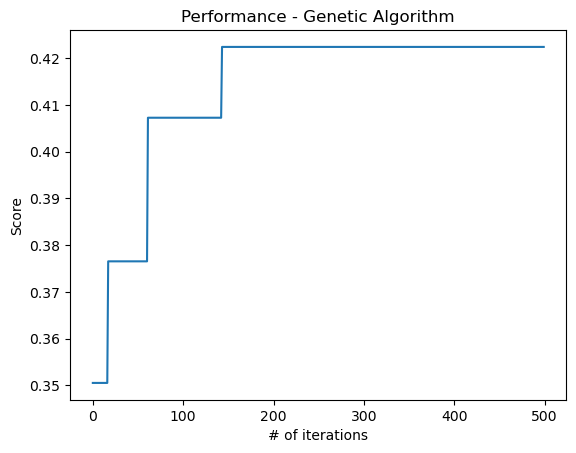

In [9]:
plt.plot(performance_ga)
plt.xlabel('# of iterations')
plt.ylabel('Score')
plt.title('Performance - Genetic Algorithm')
plt.show()

***note that running the simulated annealing algorithm takes around 10s (on same spec machine as above)***

In [12]:
n = 16  # Replace with desired number of random integers
x0 = [BusStop(i) for i in range(n)]
# random.shuffle(x0)
print("Initial Route:", x0)
print("Initial Score:", cumulative_reward(Route(x0), bus_stops_adj_matrix, passenger_adj_matrix))
solution, score, performance_sa = simulated_annealing(
    Route(x0),
    lambda x: cumulative_reward(x, bus_stops_adj_matrix, passenger_adj_matrix),
)

print("Final Score:", score)
print("Best Route:", solution)

Initial Route: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Initial Score: 0.24549737865862523
Final Score: 0.42364802339082736
Best Route: [9, 10, 7, 3, 1, 4, 11, 12, 13, 14, 15, 0, 2, 5, 6, 8]


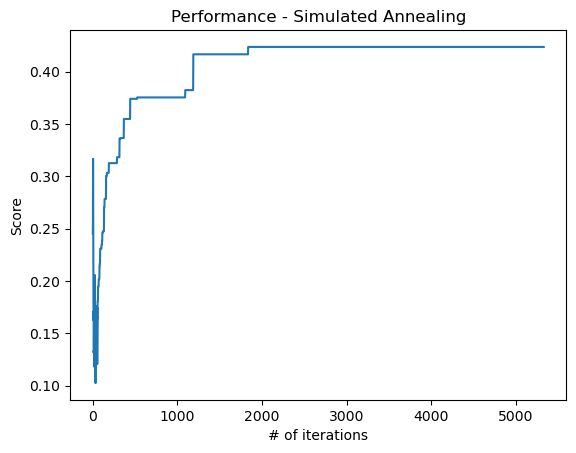

In [13]:
plt.plot(performance_sa)
plt.xlabel('# of iterations')
plt.ylabel('Score')
plt.title('Performance - Simulated Annealing')
plt.show()

## Conclusion

When comparing the graphs we can see that both graphs successfully improve the score over their iteration cycles. Both algorithms reach the same local/global optimal route with a reward score of around ~0.4. This aligns with the path that we expected the algorithm to generate.

One thing to note about the Genetic Algorithm is that it implements a concept called elitism in which it takes the best route of a generation and carries it over to the next generation. This is why the graph is smooth with sharp jumps (the score will remain the same until a new path that results in a better score appears) compared to Simulated Annealing which is random at each step. Therefore, 500 iterations were used for Genetic Algorithm to reach an optimal score compared to over 4,000 for Simulated Annealing.

The application of this project is to allow urban planners to design efficient routes for commuters that ensure that most people can reach there destination in an optimal time. By designing optimal routes commuters would be more inclined to use public transportation over personal vehicles helping both traffic and various other issues like decreasing carbon emissions.

Our project serves as an accurate representation of the current UCI bus system. The UCI Transportation and Distribution Services can use our code and modify it with their data to make their own optimized bus routes. The UCI Transportation and Distribution Services have much better data which will help improve the realistic aspect of the results. THe department can also look to modify objective function to increase the realism of the results. This project also be implemented on other campuses with extensive modification. 

Future research directions could lead towards adding a time element to the calculation. The current data is estimated based on peak hour traffic. Thus may not fully represent other times where there are less passengers. This implementation would be helpful seeking the interval between busses, an element we did not explorer during our research.

***[Written by All]***

## Bibliography
1. Allanah, Francis. “Traveling Salesman Problem Using Simulated Annealing.” Medium, 31 Jan. 2022, medium.com/@francis.allanah/travelling-salesman-problem-using-simulated-annealing-f547a71ab3c6. 
2. Chien, Steven I-Jy, et al. “Optimization of Bus Route Planning in Urban Commuter Networks.” Journal of Public 
Transportation, vol. 6, no. 1, Jan. 2003, pp. 53–79, https://doi.org/https://doi.org/10.5038/2375-0901.6.1.
3. Stoltz, Eric. “Evolution of a Salesman: A Complete Genetic Algorithm Tutorial for Python.” Medium, Towards Data Science, 17 July 2018, towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35. 
4. Zhan, Shi-hua, et al. “List-Based Simulated Annealing Algorithm for Traveling Salesman Problem.” Computational Intelligence and Neuroscience, vol. 2016, 13 Mar. 2016, https://doi.org/10.1155/2016/1712630. 
5. Zhong, Jinghui, et al. “Comparison of Performance between Different Selection Strategies on Simple Genetic Algorithms.” Comparison of Performance between Different Selection Strategies on Simple Genetic Algorithms., vol. 2, Jan. 2005, pp. 1115–1121, https://doi.org/10.1109/CIMCA.2005.1631619. 

***[Written by Vicki]***